
<div style="background-color: lightblue; padding: 10px; border-radius: 5px;">

## QSAR-based prediction of molecular solubility using physico-chemical descriptors

**Goal** Train and evaluate a regressor (e.g., LinearRegression, RandomForest, XGBoost) to predict solubility of a given molecule. The input is given by a set of physicochemical descriptors to be read in from file.
</div>


In [2]:
# Importiamo le librerie necessarie
import pandas as pd                            # per caricare e manipolare i dati
from sklearn.ensemble import RandomForestRegressor  # modello di regressione
from sklearn.model_selection import train_test_split, GridSearchCV  # per suddividere i dati in training/test set
from sklearn.metrics import mean_squared_error, r2_score  # metriche di valutazione

import matplotlib as mpl
import matplotlib.pyplot as plt                # per visualizzare i risultati
import numpy as np                             # operazioni numeriche

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.inspection import permutation_importance

import xgboost as xgb

# Set global font sizes across the notebook
mpl.rcParams['axes.titlesize'] = 16       # Title font size
mpl.rcParams['axes.labelsize'] = 16       # Axis label font size
mpl.rcParams['xtick.labelsize'] = 14      # X-axis tick label font size
mpl.rcParams['ytick.labelsize'] = 14      # Y-axis tick label font size
mpl.rcParams['legend.fontsize'] = 16      # Legend font size

In [3]:
# Carichiamo il dataset ESOL da un URL pubblico (già featurizzato)
url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv"
df = pd.read_csv(url)

print(df.columns)

Index(['Compound ID', 'ESOL predicted log solubility in mols per litre',
       'Minimum Degree', 'Molecular Weight', 'Number of H-Bond Donors',
       'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area',
       'measured log solubility in mols per litre', 'smiles'],
      dtype='object')


In [5]:
# Select by hand some features that are in the primary data to be used in the regression
features = ["Number of H-Bond Donors", "Molecular Weight", "Number of Rotatable Bonds", "Polar Surface Area"]
X = df[features].values  # matrice delle feature (input del modello)

# Extract target variable: solubility (log-scale) 
y = df["measured log solubility in mols per litre"].values

### Train default random forest regression and test on test-set, print feature importance

RMSE    : 1.075
R² Score: 0.756


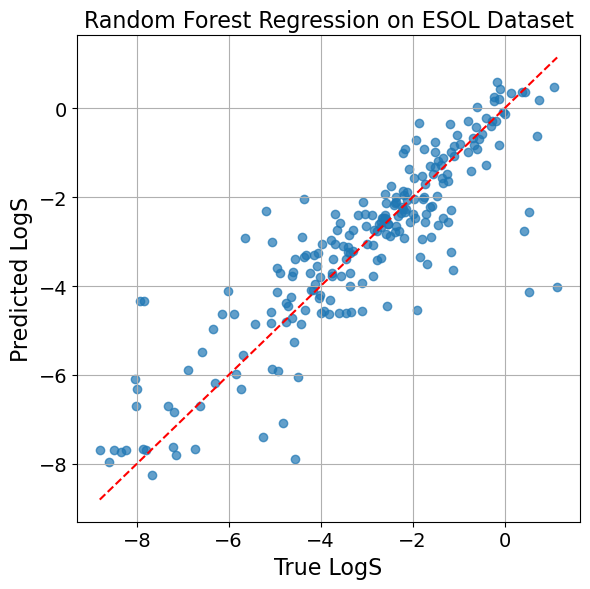

Feature importance...
Number of H-Bond Donors: 0.038
Molecular Weight: 0.647
Number of Rotatable Bonds: 0.057
Polar Surface Area: 0.257


In [6]:
# Split dataset into test (20%) and training (80%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # random_seed specified for reproducibility

# Define and train Random Forest of 100 trees
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train) 

# Predict solubility on test set
y_pred = model.predict(X_test)

# Quantify model performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # root mean square error
r2 = r2_score(y_test, y_pred)                       # R^2 coefficient
print(f"RMSE    : {rmse:.3f}")     # stampa l'errore medio
print(f"R² Score: {r2:.3f}")   # stampa la bontà dell’adattamento

# Visualizziamo le predizioni vs i valori reali
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.7)  # scatter plot
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  
plt.xlabel("True LogS")
plt.ylabel("Predicted LogS")
plt.title("Random Forest Regression on ESOL Dataset")
plt.grid(True)
plt.tight_layout()
plt.show()

# feature importance, computed like this in the RF, built-in
print('Feature importance...')
importances = model.feature_importances_
for f, imp in zip(features, importances):
    print(f"{f}: {imp:.3f}")

### Hyperparameter validation using cross validation, extract optimal model and apply to test set

In [7]:
# test different hyperparamemeters
print('Use GridSearchCV for selecting best RF estimator out of CV, span hyperparameter space')

# Set up the parameter grid: other hyperparameters may be included
param_grid = {
    'n_estimators': [10, 25, 50, 100, 200, 300]
}

# Define the model
model = RandomForestRegressor(random_state=42)

# Grid search with 5-fold cross-validation: this is built-in in scikit-learn
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,   # dictionary
                           cv=5,
                           scoring='neg_root_mean_squared_error',    # this will be 'roc_auc' for classification problems
                           n_jobs=-1,
                           verbose=1)

# Fit the model
grid_search.fit(X_train, y_train)

# Best model and performance
print(f"Best n_estimators: {grid_search.best_params_['n_estimators']}")
print(f"Best cross-validated RMSE: {-grid_search.best_score_:.3f}")

# extract best estimator/best model out of those tested
best_model = grid_search.best_estimator_

# Evaluate on test set and print rmse and r2
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R²: {r2:.3f}")

Use GridSearchCV for selecting best RF estimator out of CV, span hyperparameter space
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best n_estimators: 300
Best cross-validated RMSE: 1.037
Test RMSE: 1.069
Test R²: 0.758


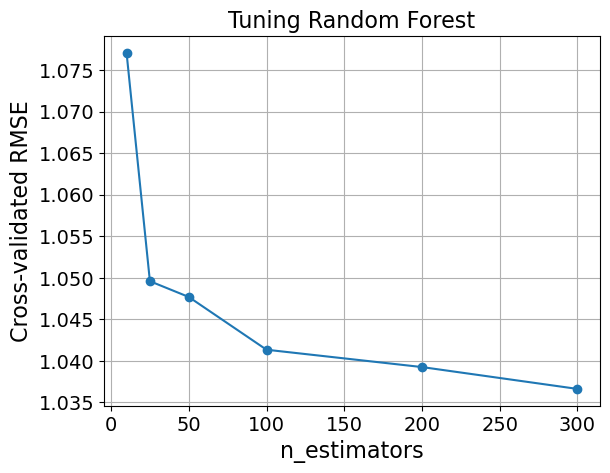

In [8]:
# grid search results are compatible with pandas dataframe to facilitate plotting
results = pd.DataFrame(grid_search.cv_results_)   # convert to data frame
plt.plot(param_grid['n_estimators'], -results['mean_test_score'], marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Cross-validated RMSE')
plt.title('Tuning Random Forest')
plt.grid(True)
plt.show()

### Test different regressors (no hyperparameter tuning) and compare performance

Linear Regression: RMSE = 1.316, R² = 0.634
Ridge: RMSE = 1.316, R² = 0.634
Lasso: RMSE = 1.306, R² = 0.639
Random Forest: RMSE = 1.076, R² = 0.755
Gradient Boosting: RMSE = 1.077, R² = 0.755
XGBoost: RMSE = 1.140, R² = 0.725


Text(0, 0.5, 'RMSE')

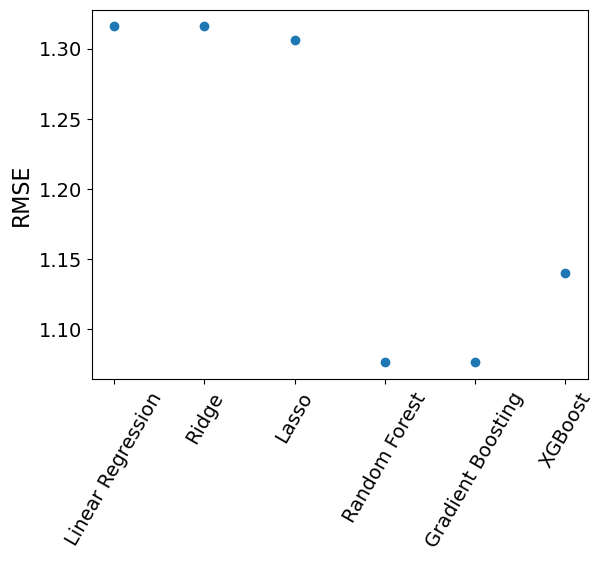

In [13]:
# Define a dictionary of models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge":  Ridge(alpha=1.0),
    "Lasso":  Lasso(alpha=0.1),
    "Random Forest":     RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
    "XGBoost":           xgb.XGBRegressor(n_estimators=200, random_state=42, verbosity=0),
    #"Support Vector Regression": SVR(kernel='rbf', C=1.0)
}

r2_all      = []
rmse_all    = []
model_label = []

# Train and evaluate each model, plot results in a compartive fashiob
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: RMSE = {rmse:.3f}, R² = {r2:.3f}")

    r2_all.append(r2)
    rmse_all.append(rmse)
    model_label.append(name)
    
# compare performance
plt.plot(range(len(rmse_all)), rmse_all, 'o')
plt.xticks(range(len(rmse_all)), model_label, rotation = 60)
plt.ylabel('RMSE')

#### SMILES-Based Property Prediction with RDKit and Random Forest

* Parsed SMILES strings to compute drug-like molecular descriptors using RDKit
* Built a supervised regression pipeline to predict aqueous solubility from computed features
* Evaluated model using RMSE and R²; visualized predictions and feature importance

In [14]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Carica il dataset con SMILES
url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv"
df = pd.read_csv(url)

# list of all descriptors avaiable in RDKIT
descriptor_list = Descriptors.descList # list of (name, function to extract that features from mol)

ModuleNotFoundError: No module named 'rdkit'

In [28]:
# Funzione per convertire un SMILES in un dizionario of pre-selected descrittori
def featurize(smiles):
    
    """ Takes in SMILES molecular representation and extract features we are interested in. Returns dictionary """
    
    # from SMILES string to "mol"
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        return None  # SMILES invalido
    
    return {
        'MolWt': Descriptors.MolWt(mol),     # lists of some descriptors that are available from mol
        'MolLogP': Descriptors.MolLogP(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),    # functions in descriptors
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumHDonors': Descriptors.NumHDonors(mol)
    }

In [29]:
# what if we want all descriptors that are avaialbe within RDKit?

def safe_featurize(smiles):
    
    """ Takes in SMILES molecular representation and extract features we are interested in. 
         Some functions cannot be applied to some molecules, account for that. 
         Returns dictionary """
    
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    result = {}
    for name, func in descriptor_list:
        try:
            result[name] = func(mol)
        except:
            result[name] = np.nan  # oppure 0, this is for when there are problems
            print(name)
    return result

In [30]:
# Applica la funzione a tutte le molecole and save results in a new variable
features = df['smiles'].apply(safe_featurize)

In [31]:
# Rimuove molecole non featurizzabili, hanlde missing data
features = features.dropna()
df = df.loc[features.index]    # align df with features
X = pd.DataFrame(features.tolist())  # converte in DataFrame
print(X.shape, features.shape)

print('              Number of samples = ' + str(X.shape[0]))
print('Number of smiles-based features = ' + str(X.shape[1]))

# Target: log solubility
y = df["measured log solubility in mols per litre"].values

# Train/test split, extract values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modello Random Forest
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Valutazione
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

(1128, 6) (1128,)
              Number of samples = 1128
Number of smiles-based features = 6
RMSE: 0.834
R²: 0.853


### Study feature importance,  using both the RF built-in function and the permutation approach

In [23]:
# feature importance

# Estrai importanza feature
importances = model.feature_importances_
feature_names = X.columns

# Crea DataFrame importanze ordinato, sort according to importance value
feat_imp_df = pd.DataFrame({
    'feat': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

n_feat = 5
print("Most n_feat important features")
print(feat_imp_df.head(n_feat))   # this is printing out the full n_feat rows of the database

# Select the feature values and their names
top_features = feat_imp_df['feat'].head(n_feat)
top_names    = feat_imp_df['importance'].head(n_feat)

Most n_feat important features
                 feat  importance
121           MolLogP    0.743755
26            BertzCT    0.023894
122             MolMR    0.023480
32              Chi1v    0.022577
14   FpDensityMorgan1    0.008544


#### Re-run regression by using just the most importance features. Fitting quality should only be incrementally worse now.

In [26]:
# Train/test split, extract values
X_train, X_test, y_train, y_test = train_test_split(X[top_features], y, test_size=0.2, random_state=42)

# use Random Forest
model = RandomForestRegressor(n_estimators=300, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

RMSE: 0.817
R²: 0.859


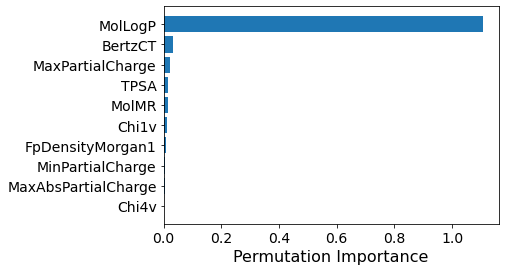

In [43]:
# permutation importance for model-agnostic importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(top_features)[sorted_idx])
plt.xlabel("Permutation Importance")
plt.show()

In [ ]:
# there is the option of using SHAP (SHapley Additive exPlanation) as a visualization method also.